In [16]:
# !pip install transformers
# !pip install tensorflow
# !pip install pytorch-nlp

In [17]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# from transformers import InputExample, InputFeatures

# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [18]:
# model.summary()

In [33]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import re



In [39]:
model_name = "bert-base-uncased-finetuned-sst-2-english"

model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

res = classifier("I hate this movie")

OSError: bert-base-uncased-finetuned-sst-2-english is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [23]:
print(res)

[{'label': 'NEGATIVE', 'score': 0.9996687173843384}]


In [ ]:
# class Config:
#     batch_size = 128
#     epochs = 10
#     embed_dim = 128
#     validation_split = 0.15
#     maxlen = 192
#     vocab_size = 10000
#     labels = np.array(["neg", "pos"])
#     num_classes = len(labels)
#     label_display_names = np.array(["Negative", "Positive"])
#     model_path = "model.tf"
# config = Config()

: 

In [29]:
# load data
data = pd.read_csv('../00_source_data/imdb_master.csv', encoding="unicode_escape")
data.head(10)

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt
5,5,test,"A funny thing happened to me while watching ""M...",neg,10004_2.txt
6,6,test,This German horror film has to be one of the w...,neg,10005_2.txt
7,7,test,"Being a long-time fan of Japanese film, I expe...",neg,10006_2.txt
8,8,test,"""Tokyo Eyes"" tells of a 17 year old Japanese g...",neg,10007_4.txt
9,9,test,Wealthy horse ranchers in Buenos Aires have a ...,neg,10008_4.txt


<AxesSubplot: >

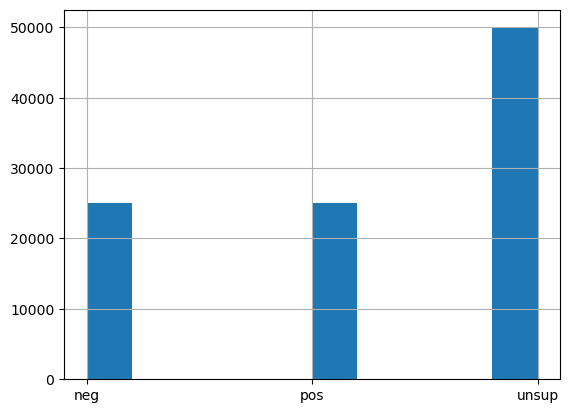

In [30]:
data["label"].hist()

In [31]:
data = data[(data["label"] == "neg") | (data["label"] == "pos")]

<AxesSubplot: >

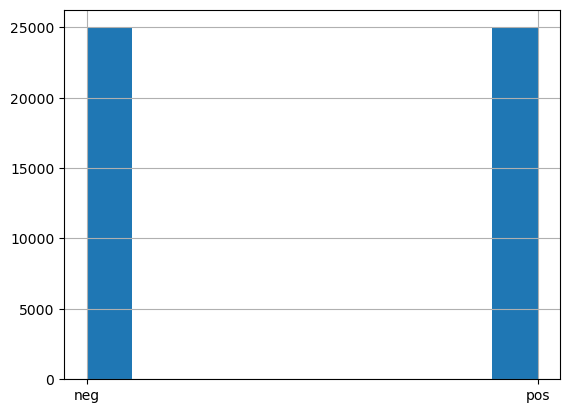

In [32]:
data["label"].hist()

## Build a TextVectorization layer

In [34]:
# data preprocessing
# 1. Remove the HTML tags
# 2. Remove any punctuations or a limited set of special characters like, or . or #, etc.
# 3. Check if the word is made up of English letters and is not alpha-numeric
# 4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
# 5. Convert the word to lowercase
# 6. Remove Stopwords (the, and, a ...)
# 7. Finally Snowball Stemming (remove -ing, -ly, ...)

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

In [35]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in data['review'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['label'].values)[i] == "pos": 
                        all_positive_words.append(s) 
                    if(data['label'].values)[i] == "neg":
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) 
    final_string.append(str1)
    i+=1

In [36]:
# add cleaned_review column
data['cleaned_review'] = final_string

In [38]:
# add score column
def posneg(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return x

filtered_score = data['label'].map(posneg)
data['score'] = filtered_score